##### In this notebook a new model checkpoint intended for summarization is tested. 

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [4]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [5]:
# Trying new model checkpoint this time
# this model was pre-trained specifically for english texts, as opposed to being multilingual like the pre-trained model used in the first two fine-tuned models
# model from https://huggingface.co/facebook/bart-large-xsum

model_checkpoint = "facebook/bart-large-xsum"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

## Tokenize data

In [6]:
# Using longer max input and target lengths for this model

def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=1024, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=1024, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs


tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [7]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-xsum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [8]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [10]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [11]:
num_train_epochs = 8
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [12]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [13]:
model_history = model.fit(tf_train, validation_data=tf_validation, epochs=8)

Epoch 1/8
212/212 [==============================] - 1271s 6s/step - loss: 3.5565 - val_loss: 3.1051
Epoch 2/8
212/212 [==============================] - 1328s 6s/step - loss: 2.8012 - val_loss: 3.1088
Epoch 3/8
212/212 [==============================] - 1430s 7s/step - loss: 2.3232 - val_loss: 3.1471
Epoch 4/8
212/212 [==============================] - 1404s 7s/step - loss: 1.9174 - val_loss: 3.3967
Epoch 5/8
212/212 [==============================] - 1336s 6s/step - loss: 1.5769 - val_loss: 3.5454
Epoch 6/8
212/212 [==============================] - 1348s 6s/step - loss: 1.3037 - val_loss: 3.8154
Epoch 7/8
212/212 [==============================] - 1317s 6s/step - loss: 1.1108 - val_loss: 3.9605
Epoch 8/8
212/212 [==============================] - 1364s 6s/step - loss: 0.9848 - val_loss: 4.0697


# Visualize model 

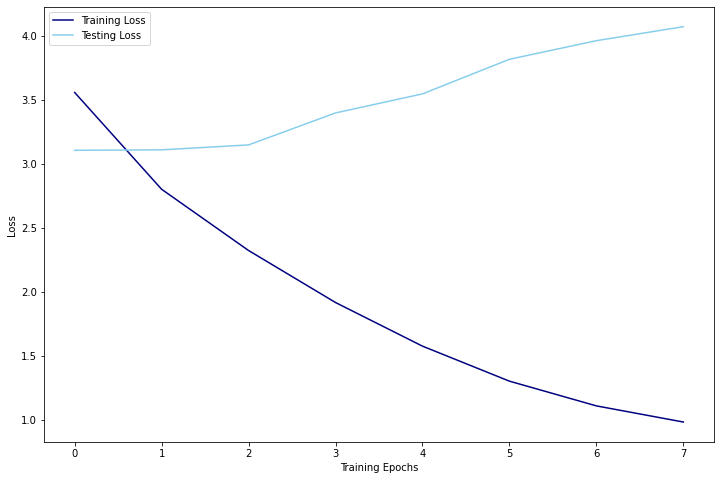

In [14]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is much higher than the loss for the training data, and is growing as the training loss increases, indicating that the model is overfitting

In [19]:
model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  406290432 
                                                                 
Total params: 406,340,696
Trainable params: 406,290,432
Non-trainable params: 50,264
_________________________________________________________________


In [1]:
train_predictions = model.predict(tf_train)

NameError: ignored

# Evaluation of Model

Model took over two hours to fit (running in Google Colab) and runtime disconnected before predictions could be extracted. However, the visualization of the training and validation loss throughout training indicate that the model was overfitting